# Garbage Classification using Xception

# Import Required Libraries

In [2]:
import numpy as np
import pandas as pd 
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import keras.applications.xception as xception
import zipfile
import sys
import time
import tensorflow.keras as keras
import tensorflow as tf
import re

from PIL import Image
from keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D, Input, GlobalAveragePooling2D
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from keras.models import Model, Sequential
from keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from keras.layers import Lambda
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

print('setup successful!')

setup successful!


# Define Constants

In [3]:
# Increasing the image size didn't result in increasing the training accuracy
IMAGE_WIDTH = 320    
IMAGE_HEIGHT = 320
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3


# Path where our data is located
base_path = "/kaggle/input/garbage-seg-10-v5/Garbage Seg 10 V5/"

# Dictionary to save our 12 classes
categories = {0: 'paper', 1: 'cardboard', 2: 'plastic', 3: 'metal', 4: 'food', 5: 'battery',
              6: 'shoes', 7: 'clothes', 8: 'glass',9: 'medical'}

print('defining constants successful!')

defining constants successful!


# Create DataFrame

We want to create a data frame that has in one column the filenames of all our images and in the other column the corresponding category. 
We Open the directories in the dataset one by one, save the filenames in the filenames_list and add the corresponding category in the categories_list

In [4]:
# Add class name prefix to filename. So for example "/paper104.jpg" become "paper/paper104.jpg"
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df

# list conatining all the filenames in the dataset
filenames_list = []
# list to store the corresponding category, note that each folder of the dataset has one class of data
categories_list = []

for category in categories:
    filenames = os.listdir(base_path + categories[category])
    
    filenames_list = filenames_list  +filenames
    categories_list = categories_list + [category] * len(filenames)
    
df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

df = add_class_name_prefix(df, 'filename')

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

print('number of elements = ' , len(df))

number of elements =  16059


In [26]:
pathtrain = '/kaggle/input/test-train2/new_train2/'
filenames1 = os.listdir(pathtrain)

In [27]:
len(filenames1)

10

In [28]:
temp = []
for i in range(10):
    temp.append('clothes')

In [29]:
for i in range(len(filenames1)):
    filenames1[i] = pathtrain+'/'+filenames1[i]

In [30]:
test_df = pd.DataFrame({
    'filename': filenames1,
    'category': temp
})

In [31]:
test_df

,filename,category
0,/kaggle/input/test-train2/new_train2//VizWiz_t...,clothes
1,/kaggle/input/test-train2/new_train2//VizWiz_t...,clothes
2,/kaggle/input/test-train2/new_train2//VizWiz_t...,clothes
3,/kaggle/input/test-train2/new_train2//VizWiz_t...,clothes
4,/kaggle/input/test-train2/new_train2//VizWiz_t...,clothes
5,/kaggle/input/test-train2/new_train2//VizWiz_t...,clothes
6,/kaggle/input/test-train2/new_train2//VizWiz_t...,clothes
7,/kaggle/input/test-train2/new_train2//VizWiz_t...,clothes
8,/kaggle/input/test-train2/new_train2//VizWiz_t...,clothes
9,/kaggle/input/test-train2/new_train2//VizWiz_t...,clothes


In [32]:
df.head(10)

,filename,category
0,shoes/shoes119.jpg,shoes
1,glass/glass2742.jpg,glass
2,clothes/clothes658.jpg,clothes
3,battery/battery792.jpg,battery
4,plastic/plastic282.jpg,plastic
5,clothes/clothes2736.jpg,clothes
6,glass/glass2751.jpg,glass
7,clothes/clothes3967.jpg,clothes
8,glass/glass2686.jpg,glass
9,paper/paper457.jpg,paper


In [12]:
validate_df

NameError: name 'validate_df' is not defined

food/food452.jpg


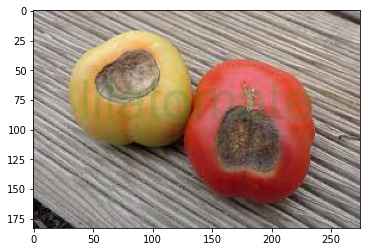

In [12]:
# see sample image, you can run the same cell again to get a different image
random_row = random.randint(0, len(df)-1)
sample = df.iloc[random_row]
randomimage = image.load_img(base_path +sample['filename'])
print(sample['filename'])
plt.imshow(randomimage)

# Viusalize the Categories Distribution

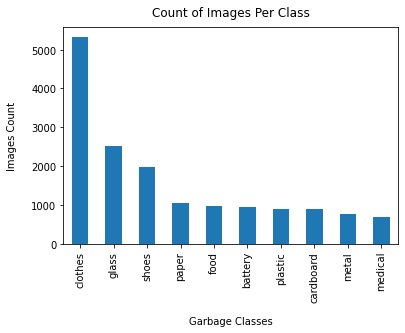

In [13]:
df_visualization = df.copy()
# Change the catgegories from numbers to names
df_visualization['category'] = df_visualization['category'].apply(lambda x:categories[x] )

df_visualization['category'].value_counts().plot.bar(x = 'count', y = 'category' )
plt.style.use('seaborn-pastel')


plt.xlabel("Garbage Classes", labelpad=14)
plt.ylabel("Images Count", labelpad=14)
plt.title("Count of Images Per Class", y=1.02);

# Create the model

The steps are:
1. Create an xception model without the last layer and load the ImageNet pretrained weights
2. Add a pre-processing layer
3. Add a pooling layer followed by a softmax layer at the end

In [14]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
import keras.applications.xception as xception

xception_layer = xception.Xception(include_top = False, input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS),
                       weights = '/kaggle/input/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5')

# We don't want to train the imported weights
xception_layer.trainable = False


model = Sequential()
model.add(keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))

#create a custom layer to apply the preprocessing
def xception_preprocessing(img):
  return xception.preprocess_input(img)

model.add(Lambda(xception_preprocessing))

model.add(xception_layer)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(len(categories), activation='softmax')) 

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 320, 320, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                20490     
Total params: 20,881,970
Trainable params: 20,490
Non-trainable params: 20,861,480
_________________________________________________________________


We will use the EarlyStopping call back to stop our training if the validation_accuray is not improving for a certain number of epochs.

In [15]:
early_stop = EarlyStopping(patience = 5, verbose = 1, monitor='val_categorical_accuracy' , mode='max', min_delta=0.001, restore_best_weights = True)

callbacks = [early_stop]

print('Call Back Defined!')

Call Back Defined!


# Split the Data Set

We split the training set into three separate sets:

1. **The training set:** used to train our model.
1. **The validation set**: used to double check that our model is not overfitting the training set, i.e. it can also generalise to other data other than the train data
1. **The Test set:** Used to estimate the accuracy of the model on new data other than the ones the model used for training
For a competition  or for some other cases, you can split the data only to training and validation sets in order to achieve the highest  possible accuracy, without the need to properly estimate how accurate the model really is.

We split the data set as follows: 80% train set, 10% cross_validation set, and 10% test set

In [16]:
#Change the categories from numbers to names
df["category"] = df["category"].replace(categories) 

# We first split the data into two sets and then split the validate_df to two sets
train_df, validate_df = train_test_split(df, test_size=0.2, random_state=42)
validate_df, test_df = train_test_split(validate_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

print('train size = ', total_validate , 'validate size = ', total_validate, 'test size = ', test_df.shape[0])

train size =  1606 validate size =  1606 test size =  1606


In [17]:
train_df.head(20)

,filename,category
0,cardboard/cardboard377.jpg,cardboard
1,plastic/plastic817.jpg,plastic
2,shoes/shoes1418.jpg,shoes
3,battery/battery80.jpg,battery
4,battery/battery408.jpg,battery
5,glass/glass2031.jpg,glass
6,plastic/plastic415.jpg,plastic
7,shoes/shoes1313.jpg,shoes
8,metal/metal517.jpg,metal
9,shoes/shoes605.jpg,shoes


# Train the model

We will first create the training data generator, that will get the images from the input data directory to train on them. We will also create a generator for the validation set.

Applying Data Augmentation on the training set was taking too long to be executed and the initial results didn't show much improvement than the results without augmentation, so I commented the augmentation to make the training faster. However fell free to uncomment the Data Augmentation lines in the following cell and play a bit with it.

In [18]:
batch_size=128

train_datagen = image.ImageDataGenerator(
    
    ###  Augmentation Start  ###
    
    #rotation_range=30,
    #shear_range=0.1,
    #zoom_range=0.3,
    #horizontal_flip=True,
    #vertical_flip = True,
    #width_shift_range=0.2,
    #height_shift_range=0.2
    
    ##  Augmentation End  ###
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    base_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 12847 validated image filenames belonging to 10 classes.


In [19]:
validation_datagen = image.ImageDataGenerator()

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    base_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1606 validated image filenames belonging to 10 classes.


In [20]:
EPOCHS = 20
history = model.fit_generator(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
100/100 [==============================] - 145s 1s/step - loss: 0.6753 - categorical_accuracy: 0.8223 - val_loss: 0.3056 - val_categorical_accuracy: 0.9225
Epoch 2/20
100/100 [==============================] - 91s 904ms/step - loss: 0.2542 - categorical_accuracy: 0.9349 - val_loss: 0.2345 - val_categorical_accuracy: 0.9290
Epoch 3/20
100/100 [==============================] - 90s 901ms/step - loss: 0.1981 - categorical_accuracy: 0.9454 - val_loss: 0.1992 - val_categorical_accuracy: 0.9414
Epoch 4/20
100/100 [==============================] - 91s 907ms/step - loss: 0.1700 - categorical_accuracy: 0.9517 - val_loss: 0.1847 - val_categorical_accuracy: 0.9421
Epoch 5/20
100/100 [==============================] - 91s 909ms/step - loss: 0.1499 - categorical_accuracy: 0.9562 - val_loss: 0.1722 - val_categorical_accuracy: 0.9460
Epoch 6/20
100/100 [==============================] - 91s 904ms/step - loss: 0.1357 - categorical_accuracy: 0.9605 - val_loss: 0.1690 - val_categorical_accur

In [22]:
model.save_weights("model87.h5")

In [23]:
model.save("model814.h5")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# Visualize the training process


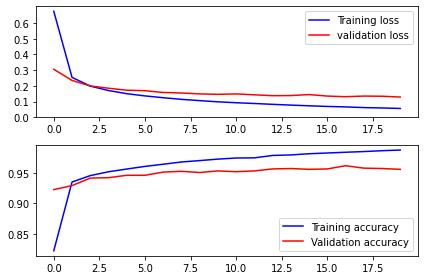

In [24]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_yticks(np.arange(0, 0.7, 0.1))
ax1.legend()

ax2.plot(history.history['categorical_accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_categorical_accuracy'], color='r',label="Validation accuracy")
ax2.legend()

legend = plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Evaluate the test

To evaluate the performance of our model we will create a test generator to load the images from the input data directory and evaluate the results.

In [33]:
test_df

,filename,category
0,/kaggle/input/test-train2/new_train2//VizWiz_t...,clothes
1,/kaggle/input/test-train2/new_train2//VizWiz_t...,clothes
2,/kaggle/input/test-train2/new_train2//VizWiz_t...,clothes
3,/kaggle/input/test-train2/new_train2//VizWiz_t...,clothes
4,/kaggle/input/test-train2/new_train2//VizWiz_t...,clothes
5,/kaggle/input/test-train2/new_train2//VizWiz_t...,clothes
6,/kaggle/input/test-train2/new_train2//VizWiz_t...,clothes
7,/kaggle/input/test-train2/new_train2//VizWiz_t...,clothes
8,/kaggle/input/test-train2/new_train2//VizWiz_t...,clothes
9,/kaggle/input/test-train2/new_train2//VizWiz_t...,clothes


In [34]:
test_datagen = image.ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    dataframe= test_df,
    directory=pathtrain,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False 
)

Found 10 validated image filenames belonging to 1 classes.


In [35]:
filenames = test_generator.filenames
nb_samples = len(filenames)

a, accuracy = model.evaluate_generator(test_generator, nb_samples)

print('Accuracy on Test Set = ',  round((accuracy * 100),2 ), '% ') 

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Accuracy on Test Set =  0.0 % 


In [36]:
accuracy

0.0

In [37]:
b = model.predict_generator(test_generator, nb_samples)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [38]:
import numpy as np

# Assuming b is a numpy array containing the predicted probabilities for multiple images
most_probable_categories = np.argmax(b, axis=1)
most_probable_category_names = [categories[i] for i in most_probable_categories]




In [39]:
most_probable_category_names
filename = "output.txt"
delimiter = ", "

my_str = delimiter.join(most_probable_category_names)




with open(filename, "w") as f:
    f.write(my_str)

print("Output saved to", filename)


Output saved to output.txt


In [32]:
b = model.predict(test_generator)

In [33]:
len(b[0])

10

In [34]:
model.evaluate

<bound method Model.evaluate of <keras.engine.sequential.Sequential object at 0x7c9b0c02b410>>

In [18]:
# We defined at the beginning of this notebook a dictionary that maps the categories number to names, but the train generator
# generated it's own dictionary and it has assigned different numbers to our categories and the predictions made by the model 
# will be made using the genrator's dictionary.

gen_label_map = test_generator.class_indices
gen_label_map = dict((v,k) for k,v in gen_label_map.items())
print(gen_label_map)

{0: 'battery', 1: 'cardboard', 2: 'clothes', 3: 'food', 4: 'glass', 5: 'medical', 6: 'metal', 7: 'paper', 8: 'plastic', 9: 'shoes'}


In [19]:
# get the model's predictions for the test set
preds = model.predict_generator(test_generator, nb_samples)

# Get the category with the highest predicted probability, the prediction is only the category's number and not name
preds = preds.argmax(1)

# Convert the predicted category's number to name 
preds = [gen_label_map[item] for item in preds]

# Convert the pandas dataframe to a numpy matrix
labels = test_df['category'].to_numpy()

print(classification_report(labels, preds))

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


              precision    recall  f1-score   support

     battery       0.95      0.96      0.95        98
   cardboard       0.89      0.92      0.91        91
     clothes       0.99      1.00      0.99       532
        food       0.98      0.98      0.98        98
       glass       0.89      0.94      0.92       250
     medical       0.95      0.92      0.93        61
       metal       0.91      0.88      0.89        88
       paper       0.92      0.90      0.91       112
     plastic       0.85      0.71      0.78        90
       shoes       0.99      0.98      0.98       186

    accuracy                           0.95      1606
   macro avg       0.93      0.92      0.92      1606
weighted avg       0.95      0.95      0.95      1606



In [52]:
pip install gradio

ERROR: Could not find a version that satisfies the requirement gradio (from versions: none)
ERROR: No matching distribution found for gradio
Note: you may need to restart the kernel to use updated packages.


In [21]:
import gradio as gr
from tensorflow.keras.models import load_model
 
# load model
model = load_model('model814.h5')

classnames = ['battery','cardboard','clothes','food','glass','medical','metal','paper','plastic','shoes']



def predict_image(img):
  img_4d=img.reshape(-1,320, 320,3)
  prediction=model.predict(img_4d)[0]
  return {classnames[i]: float(prediction[i]) for i in range(10)}

image = gr.inputs.Image(shape=(320, 320))
label = gr.outputs.Label(num_top_classes=3)
enable_queue=True
article="<p style='text-align: center'>Made by Aditya Narendra with 🖤</p>"

gr.Interface(fn=predict_image, inputs=image,  title="Garbage Classifier V5-XceptionNet",
    description="This is a Garbage Classification Model Trained using Xception Net.Deployed to Hugging Faces using Gradio.",outputs=label,article=article,enable_queue=enable_queue,interpretation='default').launch(share="True")

ModuleNotFoundError: No module named 'gradio'